# Project II: Economic Growth 

This notebook will help you getting started with analyzing the growth dataset, `growth.csv`.

In [111]:
import pandas as pd 
import numpy as np 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from scipy.stats import norm

## Read data 

In [112]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Descriptive plots

In [113]:
lbldf.loc['gdp_growth']

label     Annual growth in GDP per capita, 1970-2020
source                                            WB
Name: gdp_growth, dtype: object

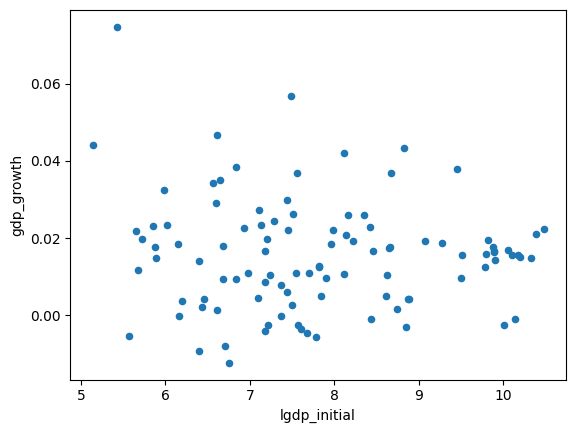

In [114]:
dat.plot.scatter(x='lgdp_initial', y='gdp_growth');

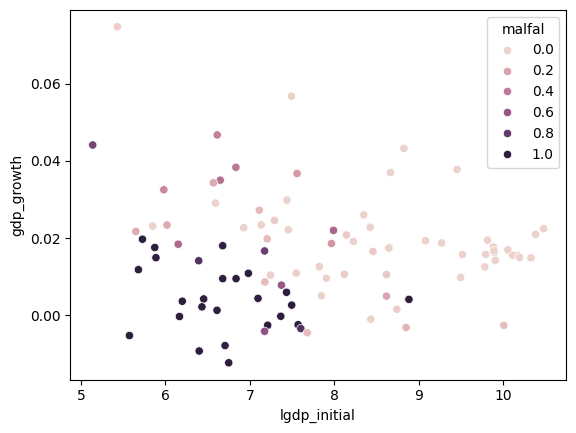

In [115]:
import seaborn as sns 
sns.scatterplot(x='lgdp_initial', y='gdp_growth', data=dat, hue='malfal');

# Collections of variables

In order to make the analysis simpler, it may be convenient to collect variables in sets that belong together naturally. 

In [116]:
# all available variables
vv_institutions = ['marketref', 'dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa', 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]


In [117]:
# convenient to keep a column of ones in the dataset
dat['constant'] = np.ones((dat.shape[0],))

# Simple OLS

In [118]:
# 1. avoiding missings 
I = dat[['gdp_growth', 'lgdp_initial']].notnull().all(axis=1)

# 2. extract dataset 
y = dat.loc[I, 'gdp_growth'].values.reshape((-1,1)) * 100.0
X = dat.loc[I, ['constant','lgdp_initial']].values

# 3. run OLS
betahat = np.linalg.inv(X.T @ X) @ X.T @ y
print(betahat)

[[ 2.24792211]
 [-0.08713416]]


# Adding more controls

In [119]:
vs = vv_all['geography'] + vv_all['religion']
xs = ['lgdp_initial', 'pop_growth', 'investment_rate'] + vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%

# Convert NaN values in X to zero
X = np.nan_to_num(X, nan=0.0)

# add const. (unless this breaks the rank condition)
oo = np.ones((I.sum(),1))
X = np.hstack([X, oo])
xs.append('constant') # we put it in as the last element

# check the rank condition
K = X.shape[1]
assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
betas = np.linalg.inv(X.T @ X) @ X.T @ y

In [120]:
# format nicely
print(f'Mean y = {y.mean(): 5.2f}% growth per year')
pd.DataFrame({'β': betas[:,0]}, index=xs).round(3)

Mean y =  1.52% growth per year


,β
lgdp_initial,-1.118
pop_growth,6.830
investment_rate,0.068
tropicar,-0.411
distr,-0.000
distcr,0.001
distc,-0.003
suitavg,-1.063
temp,-0.204
suitgini,-0.771


In [121]:
import pandas as pd
import numpy as np
import numpy.linalg as la
from sklearn.linear_model import Lasso
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures

# Load data
dat = pd.read_csv('growth.csv')

# --- Variables ---
y_col = 'gdp_growth'       # Outcome
d_col = 'lgdp_initial'     # Treatment

# --- Controls (exactly as specified) ---
controls = [
    # Institutions
    'marketref', 'dem', 'demCGV', 'demreg',
    # Geography
    'tropicar', 'distr', 'distcr', 'suitavg', 'temp', 'suitgini', 'elevavg', 'elevstd',
    'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough', 'landlock',
    'africa', 'asia', 'oceania', 'americas',
    # danger
    'yellow', 'malfal',  'uvdamage',
    # Miscellaneous
    'investment_rate', 'pop_growth'
]

# Keep relevant columns and drop rows with missing data
cols_needed = [y_col, d_col] + controls
dat_sub = dat[cols_needed].dropna()

y = dat_sub[[y_col]].values*100
d = dat_sub[[d_col]].values
Z = dat_sub[controls].values

# Add polynomial features
# Hint: remember, you don't want the constant
Z_poly = PolynomialFeatures(2, include_bias=False).fit_transform(Z)

# Display number of regressors
print("The number of regressors in Z is {}".format(Z_poly.shape[1]))

N = y.shape[0]
K = Z_poly.shape[1]
print(f"N = {N}, K_controls = {K}")


The number of regressors in Z is 464
N = 76, K_controls = 464


In [122]:
def standardize(X):
    mu = X.mean(axis=0, keepdims=True)
    sd = X.std(axis=0, ddof=1, keepdims=True)
    sd[sd == 0] = 1.0
    return (X - mu) / sd

def BRT(X_tilde, y):
    N, p = X_tilde.shape
    sigma = np.std(y, ddof=1)
    c = 1.1
    alpha = 0.05
    return float((sigma * c) / np.sqrt(N) * norm.ppf(1 - alpha / (2 * p)))

def BCCH(X_tilde,y):
    N,p = X.shape
    c = 1.1
    alpha = 0.05
    
    # Pilot penalty
    yXscale = (np.max((X_tilde.T ** 2) @ ((y-np.mean(y)) ** 2) / N)) ** 0.5
    penalty_pilot = (c / np.sqrt(N) * norm.ppf(1-alpha/(2*p)) * yXscale )# Note: Have divided by 2 due to Python definition of Lasso

    pred = Lasso(alpha=penalty_pilot).fit(X_tilde,y).predict(X_tilde)

    # Alternative: Manually
    coeff_pilot = Lasso(alpha=penalty_pilot).fit(X_tilde,y).coef_
    coef_intercept = Lasso(alpha=penalty_pilot).fit(X_tilde,y).intercept_
    pred = (coef_intercept + X_tilde@coeff_pilot)

    # Updated penalty
    eps = y - pred 
    epsXscale = (np.max((X_tilde.T ** 2) @ (eps ** 2) / N)) ** 0.5
    return c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(N)


In [124]:
X = np.column_stack([d, ])
xx = np.column_stack([np.ones(N), X])
coefs_OLS = la.inv(xx.T @ xx) @ (xx.T @ y)
alpha_OLS = float(coefs_OLS[1,0])

res = y - xx @ coefs_OLS
sigma2 = float((res.T @ res) / (N - xx.shape[1]))
var = sigma2 * la.inv(xx.T @ xx)
se_OLS = float(np.sqrt(var[1,1]))
print(f"OLS: alpha = {alpha_OLS:.4f}, se = {se_OLS:.4f}")

OLS: alpha = -0.1324, se = 0.1189


/var/folders/lh/b_r46db91n9gw9k88wgs406c0000gn/T/ipykernel_48011/892244180.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma2 = float((res.T @ res) / (N - xx.shape[1]))


In [125]:
# BCCH, 29
# Standardize data
Z_stan = standardize(Z)
X_stan = standardize(np.column_stack([d, Z]))

# Step 1: Lasso y on [d, Z]
lam_yx = BCCH(X_stan, y)
fit_yx = Lasso(alpha=lam_yx, max_iter=10000).fit(X_stan, y.ravel())
coefs_yx = fit_yx.coef_
sel_y = (coefs_yx[1:] != 0)  # skip the first (treatment)

# Step 2: Lasso d on Z
lam_dz = BCCH(Z_stan, d)
fit_dz = Lasso(alpha=lam_dz, max_iter=10000).fit(Z_stan, d.ravel())
sel_d = (fit_dz.coef_ != 0)

# Step 3: Union of selected controls
S = np.where(sel_y | sel_d)[0]
print(f"|S_y|={sel_y.sum()}, |S_d|={sel_d.sum()}, |S|={S.size}")

# Step 4: Post-OLS on d + selected controls
Z_S = Z[:, S] if S.size > 0 else np.empty((N, 0))
X_pdl = np.column_stack([np.ones(N), d, Z_S])
beta_pdl = la.inv(X_pdl.T @ X_pdl) @ (X_pdl.T @ y)
alpha_PDL = float(beta_pdl[1, 0])

res_pdl = y - X_pdl @ beta_pdl
sigma2_pdl = float((res_pdl.T @ res_pdl) / (N - X_pdl.shape[1]))
var_pdl = sigma2_pdl * la.inv(X_pdl.T @ X_pdl)
se_PDL = float(np.sqrt(var_pdl[1, 1]))

print(f"PDL: alpha = {alpha_PDL:.4f}, se = {se_PDL:.4f}")
print("Selected controls:", [controls[i] for i in S])

# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = alpha_PDL - q * se_PDL
CI_high_PDL = alpha_PDL + q * se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(5),CI_high_PDL.round(5)))
print(f"lambda_yx={lam_yx:.2f}")
print(f"lambda_dz={lam_dz:.2f}")

|S_y|=0, |S_d|=1, |S|=1
PDL: alpha = -0.6854, se = 0.1514
Selected controls: ['uvdamage']
CI_PDL =  (np.float64(-0.98206), np.float64(-0.38876))
lambda_yx=0.74
lambda_dz=0.69


/var/folders/lh/b_r46db91n9gw9k88wgs406c0000gn/T/ipykernel_48011/4050145479.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma2_pdl = float((res_pdl.T @ res_pdl) / (N - X_pdl.shape[1]))


In [ ]:
# BCCH, 434
# Standardize data
Z_stan = standardize(Z_poly)
# Use Z_poly (polynomial features) together with d for the X matrix
X_stan = standardize(np.column_stack([d, Z_poly]))

# Step 1: Lasso y on [d, Z]
lam_yx = BCCH(X_stan, y)
fit_yx = Lasso(alpha=lam_yx, max_iter=10000).fit(X_stan, y.ravel())
coefs_yx = fit_yx.coef_
sel_y = (coefs_yx[1:] != 0)  # skip the first (treatment)

# Step 2: Lasso d on Z
lam_dz = BCCH(Z_stan, d)
fit_dz = Lasso(alpha=lam_dz, max_iter=10000).fit(Z_stan, d.ravel())
sel_d = (fit_dz.coef_ != 0)

# Step 3: Union of selected controls
S = np.where(sel_y | sel_d)[0]
print(f"|S_y|={sel_y.sum()}, |S_d|={sel_d.sum()}, |S|={S.size}")

# Step 4: Post-OLS on d + selected controls
Z_S = Z_poly[:, S] if S.size > 0 else np.empty((N, 0))
X_pdl = np.column_stack([np.ones(N), d, Z_S])
beta_pdl = la.inv(X_pdl.T @ X_pdl) @ (X_pdl.T @ y)
alpha_PDL = float(beta_pdl[1, 0])

res_pdl = y - X_pdl @ beta_pdl
sigma2_pdl = float((res_pdl.T @ res_pdl) / (N - X_pdl.shape[1]))
var_pdl = sigma2_pdl * la.inv(X_pdl.T @ X_pdl)
se_PDL = float(np.sqrt(var_pdl[1, 1]))

print(f"PDL: alpha = {alpha_PDL:.4f}, se = {se_PDL:.4f}")
print("Selected controls:", [controls[i] for i in S])

# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = alpha_PDL - q * se_PDL
CI_high_PDL = alpha_PDL + q * se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(5),CI_high_PDL.round(5)))
print(f"lambda_yx={lam_yx:.2f}")
print(f"lambda_dz={lam_dz:.2f}")


|S_y|=0, |S_d|=3, |S|=3
PDL: alpha = -0.6600, se = 0.1643
CI_PDL =  (np.float64(-0.98198), np.float64(-0.33798))
lambda_yx=1.32
lambda_dz=0.82


/var/folders/lh/b_r46db91n9gw9k88wgs406c0000gn/T/ipykernel_48011/2945165372.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma2_pdl = float((res_pdl.T @ res_pdl) / (N - X_pdl.shape[1]))


In [101]:
# BRT, 29 
# Standardize data
Z_stan = standardize(Z)
X_stan = standardize(np.column_stack([d, Z]))

# Step 1: Lasso y on [d, Z]
lam_yx = BRT(X_stan, y)
fit_yx = Lasso(alpha=lam_yx, max_iter=10000).fit(X_stan, y.ravel())
coefs_yx = fit_yx.coef_
sel_y = (coefs_yx[1:] != 0)  # skip the first (treatment)

# Step 2: Lasso d on Z
lam_dz = BRT(Z_stan, d)
fit_dz = Lasso(alpha=lam_dz, max_iter=10000).fit(Z_stan, d.ravel())
sel_d = (fit_dz.coef_ != 0)

# Step 3: Union of selected controls
S = np.where(sel_y | sel_d)[0]
print(f"|S_y|={sel_y.sum()}, |S_d|={sel_d.sum()}, |S|={S.size}")

# Step 4: Post-OLS on d + selected controls
Z_S = Z[:, S] if S.size > 0 else np.empty((N, 0))
X_pdl = np.column_stack([np.ones(N), d, Z_S])
beta_pdl = la.inv(X_pdl.T @ X_pdl) @ (X_pdl.T @ y)
alpha_PDL = float(beta_pdl[1, 0])

res_pdl = y - X_pdl @ beta_pdl
sigma2_pdl = float((res_pdl.T @ res_pdl) / (N - X_pdl.shape[1]))
var_pdl = sigma2_pdl * la.inv(X_pdl.T @ X_pdl)
se_PDL = float(np.sqrt(var_pdl[1, 1]))

print(f"PDL: alpha = {alpha_PDL:.4f}, se = {se_PDL:.4f}")
print("Selected controls:", [controls[i] for i in S])

# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = alpha_PDL - q * se_PDL
CI_high_PDL = alpha_PDL + q * se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(5),CI_high_PDL.round(5)))
print(f"lambda_yx={lam_yx:.4f}")
print(f"lambda_dz={lam_dz:.4f}")

|S_y|=2, |S_d|=2, |S|=4
PDL: alpha = -0.8262, se = 0.1450
Selected controls: ['africa', 'asia', 'malfal', 'uvdamage']
CI_PDL =  (np.float64(-1.11042), np.float64(-0.54198))
lambda_yx=0.5736
lambda_dz=0.5544


/var/folders/lh/b_r46db91n9gw9k88wgs406c0000gn/T/ipykernel_48011/8961681.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma2_pdl = float((res_pdl.T @ res_pdl) / (N - X_pdl.shape[1]))


In [102]:
# BRT, 434 
# Standardize data
Z_stan = standardize(Z_poly)
X_stan = standardize(np.column_stack([d, Z_poly]))

# Step 1: Lasso y on [d, Z]
lam_yx = BRT(X_stan, y)
fit_yx = Lasso(alpha=lam_yx, max_iter=10000).fit(X_stan, y.ravel())
coefs_yx = fit_yx.coef_
sel_y = (coefs_yx[1:] != 0)  # skip the first (treatment)

# Step 2: Lasso d on Z
lam_dz = BRT(Z_stan, d)
fit_dz = Lasso(alpha=lam_dz, max_iter=10000).fit(Z_stan, d.ravel())
sel_d = (fit_dz.coef_ != 0)

# Step 3: Union of selected controls (these are indices into Z_poly)
S = np.where(sel_y | sel_d)[0]
print(f"|S_y|={sel_y.sum()}, |S_d|={sel_d.sum()}, |S|={S.size}")

# Step 4: Post-OLS on d + selected controls
# IMPORTANT: when using Z_poly, use Z_poly[:, S] (not Z) because S indexes the polynomial-feature columns
Z_S = Z_poly[:, S] if S.size > 0 else np.empty((N, 0))
X_pdl = np.column_stack([np.ones(N), d, Z_S])
beta_pdl = la.inv(X_pdl.T @ X_pdl) @ (X_pdl.T @ y)
alpha_PDL = float(beta_pdl[1, 0])

res_pdl = y - X_pdl @ beta_pdl
sigma2_pdl = float((res_pdl.T @ res_pdl) / (N - X_pdl.shape[1]))
var_pdl = sigma2_pdl * la.inv(X_pdl.T @ X_pdl)
se_PDL = float(np.sqrt(var_pdl[1, 1]))

print(f"PDL: alpha = {alpha_PDL:.4f}, se = {se_PDL:.4f}")

# Try to print human-readable feature names for selected polynomial features.
# PolynomialFeatures is available in the notebook; reconstruct feature names from the original Z columns.
try:
	poly = PolynomialFeatures(2, include_bias=False)
	# fit on Z to get the same feature ordering used to build Z_poly
	poly.fit(Z)
	feat_names = poly.get_feature_names_out(controls)
	selected_names = [feat_names[i] for i in S]
	print("Selected polynomial features:", selected_names)
except Exception:
	# fallback: just print the indices
	print("Selected polynomial feature indices:", S.tolist())

# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = alpha_PDL - q * se_PDL
CI_high_PDL = alpha_PDL + q * se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(5),CI_high_PDL.round(5)))
print(f"lambda_yx={lam_yx:.4f}")
print(f"lambda_dz={lam_dz:.4f}")

|S_y|=1, |S_d|=3, |S|=4
PDL: alpha = -0.3226, se = 0.1456
Selected polynomial features: ['uvdamage', 'marketref abslat', 'demreg abslat', 'cenlong asia']
CI_PDL =  (np.float64(-0.60806), np.float64(-0.03715))
lambda_yx=0.7066
lambda_dz=0.6850


/var/folders/lh/b_r46db91n9gw9k88wgs406c0000gn/T/ipykernel_48011/2323362347.py:29: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma2_pdl = float((res_pdl.T @ res_pdl) / (N - X_pdl.shape[1]))


In [50]:
import pandas as pd

pd.DataFrame({
    'alpha': [alpha_OLS, alpha_PDL, ],
    'se':    [se_OLS,    se_PDL,    ]
}, index=['OLS', 'PDL']).round(4)


,alpha,se
OLS,-0.0117,0.0016
PDL,-0.0032,0.0015


In [51]:
import numpy as np
import numpy.linalg as la

# Outcome and treatment only
y = dat[['gdp_growth']].dropna().values.reshape(-1,1)
d = dat.loc[dat['gdp_growth'].notna(), ['lgdp_initial']].values.reshape(-1,1)
N = y.shape[0]

# Add constant
X = np.column_stack([np.ones(N), d])

# OLS estimate
beta_hat = la.inv(X.T @ X) @ (X.T @ y)
alpha_unrestricted = float(beta_hat[1,0])

# Residuals and standard error
res = y - X @ beta_hat
sigma2 = float((res.T @ res) / (N - X.shape[1]))
var = sigma2 * la.inv(X.T @ X)
se_unrestricted = float(np.sqrt(var[1,1]))

print(f"Unrestricted OLS (no controls):")
print(f"  alpha = {alpha_unrestricted:.4f}")
print(f"  SE(alpha) = {se_unrestricted:.4f}")


Unrestricted OLS (no controls):
  alpha = -0.0009
  SE(alpha) = 0.0011


/var/folders/lh/b_r46db91n9gw9k88wgs406c0000gn/T/ipykernel_48011/3798371678.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma2 = float((res.T @ res) / (N - X.shape[1]))


In [52]:
import numpy as np
import numpy.linalg as la

# Outcome (y) and treatment (d)
dat_sub = dat[['gdp_growth', 'lgdp_initial']].dropna()
y = dat_sub[['gdp_growth']].values.reshape(-1,1)
d = dat_sub[['lgdp_initial']].values.reshape(-1,1)

N = y.shape[0]  # number of usable observations

# Add constant term
X = np.column_stack([np.ones(N), d])

# OLS estimation
beta_hat = la.inv(X.T @ X) @ (X.T @ y)
alpha_unrestricted = float(beta_hat[1,0])

# Residuals and standard errors
res = y - X @ beta_hat
sigma2 = float((res.T @ res) / (N - X.shape[1]))
var = sigma2 * la.inv(X.T @ X)
se_unrestricted = float(np.sqrt(var[1,1]))

print(f"Unrestricted OLS (no controls):")
print(f"  Observations (N) = {N}")
print(f"  alpha = {alpha_unrestricted:.4f}")
print(f"  SE(alpha) = {se_unrestricted:.4f}")


Unrestricted OLS (no controls):
  Observations (N) = 102
  alpha = -0.0009
  SE(alpha) = 0.0011


/var/folders/lh/b_r46db91n9gw9k88wgs406c0000gn/T/ipykernel_48011/2326935641.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  sigma2 = float((res.T @ res) / (N - X.shape[1]))


In [56]:
import pandas as pd
import numpy as np

# ---- compute t-statistics ----
tstat_ols = alpha_unrestricted / se_unrestricted
tstat_pdl = alpha_PDL / se_PDL

# ---- count controls ----
controls_total = len(controls)
nonzero_controls = np.sum(sel_y | sel_d)

# ---- BRT penalties ----
lambda_dz = lam_dz
lambda_yx = lam_yx

# ---- assemble the table ----
table = pd.DataFrame({
    'Model': ['OLS', 'PDL (BRT)'],
    'Initial log(gdp)': [alpha_unrestricted, alpha_PDL],
    'se': [se_unrestricted, se_PDL],
    'Controls': [0, controls_total],
    'Non-zero controls': [0, nonzero_controls],
    'Observations': [N, N],
    'Penalty term': ['-', 'BRT'],
    'λ_dz': ['-', f"{lambda_dz:.4f}"],
    'λ_yx': ['-', f"{lambda_yx:.4f}"],
    't-statistic': [tstat_ols, tstat_pdl]
})

# format nicely
table = table.round({
    'Initial log(gdp)': 4, 'se': 4, 't-statistic': 4
})

print("Estimation Results (simplified Table 2 style):")
display(table)


Estimation Results (simplified Table 2 style):


,Model,Initial log(gdp),se,Controls,Non-zero controls,Observations,Penalty term,λ_dz,λ_yx,t-statistic
0,OLS,-0.0009,0.0011,0,0,71,-,-,-,-0.8212
1,PDL (BRT),-0.0056,0.0015,28,1,71,BRT,0.9201,0.0121,-3.6998
